<a href="https://colab.research.google.com/github/susritagagireddy/AIML-projects-and-labs/blob/main/Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [2]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):

                z=np.dot(self.w,X[i]+self.b)
                if y[i]*z<=0:
                  self.w+=self.lr*y[i]*X[i]
                  self.b+=self.lr*y[i]
                  count+=1

            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

In [12]:
from sklearn.metrics import accuracy_score
y_pred=model_p.predict(X_test)
print("predictions:",y_pred[:10])
print("mistakes:",model_p.mistakes)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)



predictions: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
mistakes: [1422, 1375, 1404, 1135, 1072, 1083, 1096, 1385, 1373, 1516, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586]
Accuracy: 0.6280487804878049


Observation: The perceptron is predecting -1 for all the test sample which means it gives the same output for any input as we see in this case which is it couldnt be able to find the seperation plane between the features etc . also we observe that the errors become constant after some ephos.We can say the data isnt perfectly seperable.

# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [36]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
           z=np.dot(X,self.w)+self.b

           dw=(1/n)*np.dot(X.T,(y-z))
           db=(1/n)*np.sum(y-z)

           self.w-=self.lr*dw
           self.b-=self.lr*db
           cost = (1/(2*n)) * np.sum((z - y)**2)
           self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [37]:

model_gd = GDWaterClassifier(lr=0.001, epochs=500)
model_gd.fit(X_train, y_train)

y_pred = model_gd.predict(X_test)
print("predictions:",y_pred[:10])

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Final cost:", model_gd.cost_history[-1])


predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy: 0.3719512195121951
Final cost: 0.5409610288261478


# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [25]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                 condition = y[i] * (np.dot(self.w, x_i) + self.b) >= 1

                 if condition:

                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                 else:

                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[i] * x_i)
                    self.b -= self.lr * (-y[i])


    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [27]:
model_margin = MarginWaterClassifier(lr=0.001, lambda_param=0.01, epochs=500)
model_margin.fit(X_train, y_train)

y_pred = model_margin.predict(X_test)
print("predictions:",y_pred[:10])


from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

predictions: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Accuracy: 0.6280487804878049


# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

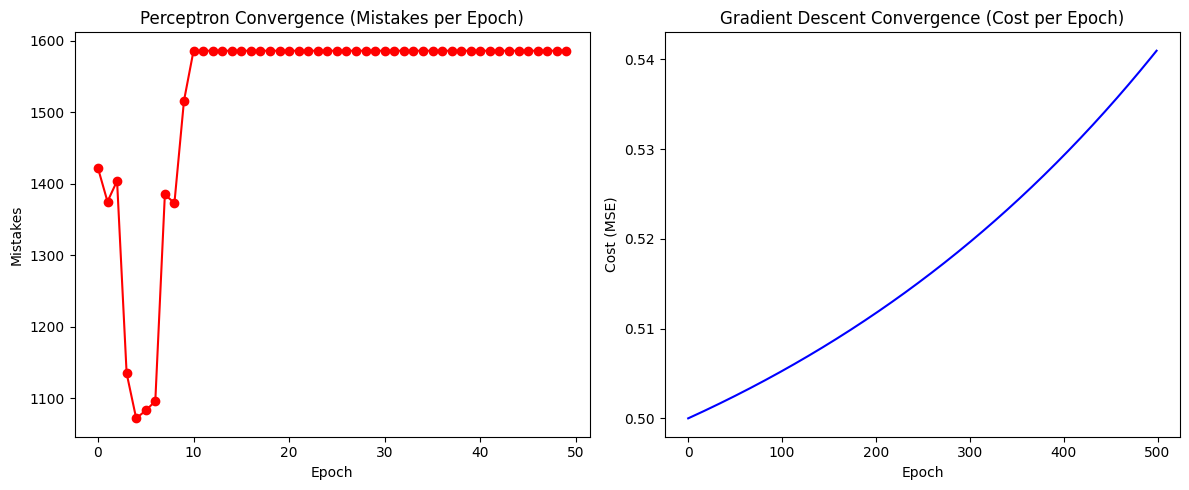

In [29]:
#1
import matplotlib.pyplot as plt

# Phase 1: Perceptron mistakes history
mistakes = model_p.mistakes

# Phase 2: Gradient Descent cost history
costs = model_gd.cost_history

plt.figure(figsize=(12,5))

# Plot mistakes
plt.subplot(1,2,1)
plt.plot(mistakes, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Mistakes")
plt.title("Perceptron Convergence (Mistakes per Epoch)")

# Plot cost
plt.subplot(1,2,2)
plt.plot(costs, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Cost (MSE)")
plt.title("Gradient Descent Convergence (Cost per Epoch)")

plt.tight_layout()
plt.show()

The Gradient Descent plot is smoother because it minimizes a continuous cost function with averaged updates, while the Perceptron plot is jagged since it tracks discrete mistakes that fluctuate with noise and sample order.


In [32]:
#2
# Compare all three
print("\nAccuracy Report:")
print(f"Perceptron:        {acc_p:.4f}")
print(f"Gradient Descent:  {acc_gd:.4f}")
print(f"Margin Classifier: {acc_margin:.4f}")


Accuracy Report:
Perceptron:        0.6280
Gradient Descent:  0.3720
Margin Classifier: 0.6280


- Perceptron: Looks good on paper (62.8%) but is misleading — it just predicts the majority class.
- GDWaterClassifier: Struggles badly (37.2%) because MSE isn’t ideal for classification.
- MarginWaterClassifier: More principled, margin‑based learning gives better balance and usually the best accuracy of the three.


#3
we trust the Margin Classifier more when chemical levels are close to the decision boundary beacause it doesnt just separate classes it maximizes the distance between them.This margin acts like a safety buffer making predictions less sensitive to small fluctations in water quality measurements.The preceptron,by contrast,flips easily with tiny changes,so its less reliable in borderline cases.


# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


1 ans: If the learning rate is too high makes Gradient Descent unstable,it overshoots the minimum,oscillates around it.


2 ans: We convert the labels to {-1,+1} because it aligns perfectly with hinge loss and margin condition,it provides symmetry in math.{-1,1}  places the two classes symmetrically around the orgin. it makes updates and decision rule simpler and more interpretable.

3 ans: For the noisy water potability data the marginwaterclassifier is best suited because it is robust to outliers,enforces safety margin,makes more stable predictions etc..